# Assignment 2

### Question 5

In [1]:
import vugrad as vg
import numpy as np

In [2]:
a = vg.TensorNode(np.random.randn(2, 2))
b = vg.TensorNode(np.random.randn(2, 2))

In [3]:
c = a + b
c

In [4]:
c.value

array([[ 1.06719234, -1.66014825],
       [ 1.44832347, -0.85405275]])

In [5]:
c.source

In [8]:
c.source.op

vugrad.core.Add

In [6]:
c.source.inputs

(<vugrad.core.TensorNode at 0x7fd743ff6190>,
 <vugrad.core.TensorNode at 0x7fd743ff6a30>)

In [7]:
a.grad

array([[0., 0.],
       [0., 0.]])

### Question 9

In [65]:
class ReLU(vg.Op):
    """
    Op for ReLU activation.
    """
    @staticmethod
    def forward(context, input):

        pos = np.maximum(input, 0)
        context['pos'] = pos # store the relu of x for the backward pass
        return pos

    @staticmethod
    def backward(context, goutput):
        pos = context['pos'] # retrieve the relu of x
        return goutput * (pos > 0).astype(int)

In [66]:
import numpy as np
import vugrad as vg

dataset = 'synth'
batch_size = 128
epochs = 20
learning_rate = 0.001

## Load the data
if dataset == 'synth':
    (xtrain, ytrain), (xval, yval), num_classes = vg.load_synth()
elif dataset == 'mnist':
    (xtrain, ytrain), (xval, yval), num_classes = vg.load_mnist(final=False, flatten=True)
else:
    raise Exception(f'Dataset {dataset} not recognized.')

print(f'## loaded data:')
print(f'         number of instances: {xtrain.shape[0]} in training, {xval.shape[0]} in validation')
print(f' training class distribution: {np.bincount(ytrain)}')
print(f'     val. class distribution: {np.bincount(yval)}')

num_instances, num_features = xtrain.shape


## loaded data:
         number of instances: 60000 in training, 10000 in validation
 training class distribution: [32461 27539]
     val. class distribution: [5456 4544]


In [67]:
# Create a simple neural network.
# This is a `Module` consisting of other modules representing linear layers, provided by the vugrad library.
class MLP(vg.Module):
    """
    A simple MLP with one hidden layer, and a sigmoid non-linearity on the hidden layer and a softmax on the
    output.
    """

    def __init__(self, input_size, output_size, hidden_mult=4):
        """
        :param input_size:
        :param output_size:
        :param hidden_mult: Multiplier that indicates how many times bigger the hidden layer is than the input layer.
        """
        super().__init__()

        hidden_size = hidden_mult * input_size
        # -- There is no common wisdom on how big the hidden size should be, apart from the idea
        #    that it should be strictly _bigger_ than the input if at all possible.

        self.layer1 = vg.Linear(input_size, hidden_size)
        self.layer2 = vg.Linear(hidden_size, output_size)
        # -- The linear layer (without activation) is implemented in vugrad. We simply instantiate these modules, and
        #    add them to our network.

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        hidden = vg.sigmoid(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    def parameters(self):

        return self.layer1.parameters() + self.layer2.parameters()

In [68]:
def train(mlp, xtrain, ytrain, xval, yval, batch_size=128, epochs=20, learning_rate=0.01):
    n, m = xtrain.shape
    b = batch_size

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }

    print('\n## Starting training')
    for epoch in range(epochs):

        print(f'epoch {epoch:03}')

        ## Compute validation accuracy
        o = mlp(vg.TensorNode(xval))
        oval = o.value

        predictions = np.argmax(oval, axis=1)
        num_correct = (predictions == yval).sum()
        acc = num_correct / yval.shape[0]

        o.clear() # gc the computation graph
        print(f'       accuracy: {acc:.4}')

        cl = 0.0 # running sum of the training loss

        # We loop over the data in batches of size `b`
        for fr in range(0, n, b):

            # The end index of the batch
            to = min(fr + b, n)

            # Slice out the batch and its corresponding target values
            batch, targets = xtrain[fr:to, :], ytrain[fr:to]

            # Wrap the inputs in a Node
            batch = vg.TensorNode(value=batch)

            outputs = mlp(batch)
            loss = vg.logceloss(outputs, targets)
            # -- The computation graph is now complete. It consists of the MLP, together with the computation of
            #    the scalar loss.
            # -- The variable `loss` is the TensorNode at the very top of our computation graph. This means we can call
            #    it to perform operations on the computation graph, like clearing the gradients, starting the backpropgation
            #    and clearing the graph.
            # -- Note that we set the MLP up to produce log probabilties, so we should compute the CE loss for these.

            cl += loss.value
            # -- We must be careful here to extract the _raw_ value for the running loss. What would happen if we kept
            #    a running sum using the TensorNode?

            # Start the backpropagation
            loss.backward()

            # pply gradient descent
            for parm in mlp.parameters():
                parm.value -= learning_rate * parm.grad
                # -- Note that we are directly manipulating the members of the parm TensorNode. This means that for this
                #    part, we are not building up a computation graph.

            # -- In Pytorch, the gradient descent is abstracted away into an Optimizer. This allows us to build slightly more
            #    complexoptimizers than plain graident descent.

            # Finally, we need to reset the gradients to zero ...
            loss.zero_grad()
            # ... and delete the parts of the computation graph we don't need to remember.
            loss.clear()

        # cslculate metrics
        metrics['train_loss'].append(cl)
        metrics['val_acc'].append(acc)

        outputs = mlp(vg.TensorNode(xval))
        loss = vg.logceloss(outputs, yval)
        metrics['val_loss'].append(loss.value)

        loss.zero_grad()
        loss.clear()

        print(f'   running loss: {cl/n:.4}')
        
    return mlp, metrics

In [69]:
class MLP_relu(MLP):
    def __init__(self, input_size, output_size, hidden_mult=4):
        super().__init__(input_size, output_size, hidden_mult)

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        hidden = ReLU.do_forward(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    

In [70]:
## Instantiate the model
mlp = MLP(input_size=num_features, output_size=num_classes)
mlp, metrics = train(mlp, xtrain, ytrain, xval, yval, learning_rate=learning_rate)


## Starting training
epoch 000
       accuracy: 0.4533
   running loss: 0.6892
epoch 001
       accuracy: 0.5574
   running loss: 0.6668
epoch 002
       accuracy: 0.756
   running loss: 0.5247
epoch 003
       accuracy: 0.9243
   running loss: 0.2924
epoch 004
       accuracy: 0.9407
   running loss: 0.202
epoch 005
       accuracy: 0.944
   running loss: 0.1708
epoch 006
       accuracy: 0.944
   running loss: 0.1559
epoch 007
       accuracy: 0.9446
   running loss: 0.1467
epoch 008
       accuracy: 0.9464
   running loss: 0.139
epoch 009
       accuracy: 0.9492
   running loss: 0.1313
epoch 010
       accuracy: 0.9529
   running loss: 0.1232
epoch 011
       accuracy: 0.9567
   running loss: 0.1152
epoch 012
       accuracy: 0.961
   running loss: 0.1081
epoch 013
       accuracy: 0.9642
   running loss: 0.1021
epoch 014
       accuracy: 0.9665
   running loss: 0.09739
epoch 015
       accuracy: 0.969
   running loss: 0.09357
epoch 016
       accuracy: 0.9707
   running loss: 0.09

In [71]:
mlp_relu = MLP_relu(input_size=num_features, output_size=num_classes)
mlp_relu, metrics_relu = train(mlp_relu, xtrain, ytrain, xval, yval, learning_rate=learning_rate)


## Starting training
epoch 000
       accuracy: 0.437
   running loss: 0.2407
epoch 001
       accuracy: 0.9816
   running loss: 0.09041
epoch 002
       accuracy: 0.9881
   running loss: 0.06755
epoch 003
       accuracy: 0.989
   running loss: 0.05726
epoch 004
       accuracy: 0.9887
   running loss: 0.05087
epoch 005
       accuracy: 0.9895
   running loss: 0.04586
epoch 006
       accuracy: 0.9902
   running loss: 0.04156
epoch 007
       accuracy: 0.9913
   running loss: 0.03823
epoch 008
       accuracy: 0.992
   running loss: 0.03572
epoch 009
       accuracy: 0.9926
   running loss: 0.03364
epoch 010
       accuracy: 0.9926
   running loss: 0.03193
epoch 011
       accuracy: 0.9929
   running loss: 0.03049
epoch 012
       accuracy: 0.9939
   running loss: 0.02927
epoch 013
       accuracy: 0.9945
   running loss: 0.02823
epoch 014
       accuracy: 0.9946
   running loss: 0.02732
epoch 015
       accuracy: 0.9947
   running loss: 0.02652
epoch 016
       accuracy: 0.9948
   r

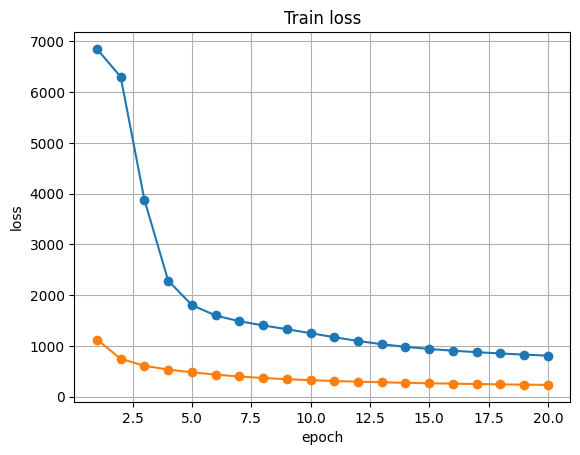

In [74]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), metrics['val_loss'], marker='o', label='sigmoid activation')
plt.plot(range(1, epochs + 1), metrics_relu['val_loss'], marker='o', label='ReLU activation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

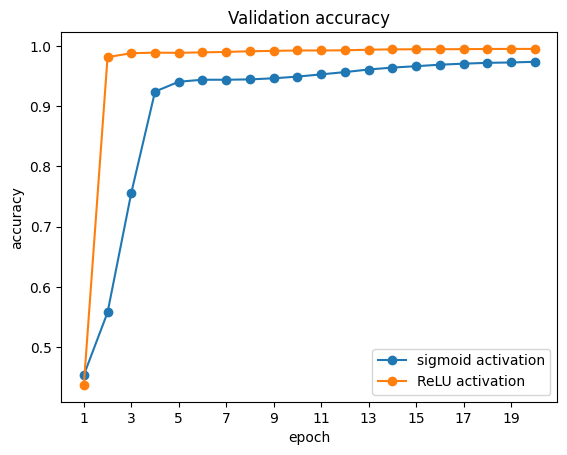

In [78]:
plt.plot(range(1, epochs + 1), metrics['val_acc'], marker='o', label='sigmoid activation')
plt.plot(range(1, epochs + 1), metrics_relu['val_acc'], marker='o', label='ReLU activation')
plt.xticks(range(1, epochs+1, 2))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation accuracy')
# plt.grid()
plt.legend()

### Question 10

In [17]:
import numpy as np
import vugrad as vg

In [42]:
dataset = 'synth'
batch_size = 128
epochs = 7
learning_rate = 0.001
momentum = 0.9

In [43]:
## Load the data
(xtrain, ytrain), (xval, yval), num_classes = vg.load_mnist(final=False, flatten=True)
xtrain = (xtrain - np.min(xtrain)) / (np.max(xtrain) - np.min(xtrain))
xval = (xval - np.min(xtrain)) / (np.max(xtrain) - np.min(xtrain))


print(f'## loaded data:')
print(f'         number of instances: {xtrain.shape[0]} in training, {xval.shape[0]} in validation')
print(f' training class distribution: {np.bincount(ytrain)}')
print(f'     val. class distribution: {np.bincount(yval)}')

num_instances, num_features = xtrain.shape


## loaded data:
         number of instances: 55000 in training, 5000 in validation
 training class distribution: [5434 6212 5465 5622 5343 4963 5436 5702 5357 5466]
     val. class distribution: [489 530 493 509 499 458 482 563 494 483]


In [44]:
class ReLU(vg.Op):
    """
    Op for ReLU activation.
    """
    @staticmethod
    def forward(context, input):

        pos = np.maximum(input, 0)
        context['pos'] = pos # store the relu of x for the backward pass
        return pos

    @staticmethod
    def backward(context, goutput):
        pos = context['pos'] # retrieve the relu of x
        return goutput * (pos > 0).astype(int)

In [45]:
# Create a simple neural network.
# This is a `Module` consisting of other modules representing linear layers, provided by the vugrad library.
class MLP2(vg.Module):
    """
    A simple MLP with one hidden layer, and a sigmoid non-linearity on the hidden layer and a softmax on the
    output.
    """

    def __init__(self, input_size, output_size, hidden_mult=4):
        """
        :param input_size:
        :param output_size:
        :param hidden_mult: Multiplier that indicates how many times bigger the hidden layer is than the input layer.
        """
        super().__init__()

        self.name = 'MLP2'
        hidden_size = hidden_mult * input_size
        # -- There is no common wisdom on how big the hidden size should be, apart from the idea
        #    that it should be strictly _bigger_ than the input if at all possible.

        self.layer1 = vg.Linear(input_size, hidden_size)
        self.layer2 = vg.Linear(hidden_size, output_size)
        # -- The linear layer (without activation) is implemented in vugrad. We simply instantiate these modules, and
        #    add them to our network.

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        # hidden = vg.sigmoid(hidden)
        hidden = ReLU.do_forward(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    def parameters(self):

        return self.layer1.parameters() + self.layer2.parameters()

In [46]:
# Create a simple neural network.
# This is a `Module` consisting of other modules representing linear layers, provided by the vugrad library.
class MLP3(vg.Module):
    """
    A simple MLP with one hidden layer, and a sigmoid non-linearity on the hidden layer and a softmax on the
    output.
    """

    def __init__(self, input_size, output_size, hidden_mult=4):
        """
        :param input_size:
        :param output_size:
        :param hidden_mult: Multiplier that indicates how many times bigger the hidden layer is than the input layer.
        """
        super().__init__()
        
        self.name = 'MLP3'
        hidden_size = hidden_mult * input_size
        # -- There is no common wisdom on how big the hidden size should be, apart from the idea
        #    that it should be strictly _bigger_ than the input if at all possible.

        self.layer1 = vg.Linear(input_size, hidden_mult * input_size)
        self.layer2 = vg.Linear(hidden_mult * input_size, 2 * hidden_mult * input_size)
        self.layer3 = vg.Linear(2 * hidden_mult * input_size, output_size)
        # -- The linear layer (without activation) is implemented in vugrad. We simply instantiate these modules, and
        #    add them to our network.

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity
        # hidden = vg.sigmoid(hidden)
        hidden = ReLU.do_forward(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        hidden = self.layer2(hidden)
        hidden = ReLU.do_forward(hidden)

        # third layer
        output = self.layer3(hidden)


        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    def parameters(self):

        return self.layer1.parameters() + self.layer2.parameters()

In [47]:
def train(mlp, xtrain, ytrain, xval, yval, batch_size=128, epochs=20, learning_rate=0.01, momentum=0.):
    n, m = xtrain.shape
    b = batch_size

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }

    print('\n## Starting training')
    for epoch in range(epochs):

        print(f'epoch {epoch:03}')

        ## Compute validation accuracy
        o = mlp(vg.TensorNode(xval))
        oval = o.value

        predictions = np.argmax(oval, axis=1)
        num_correct = (predictions == yval).sum()
        acc = num_correct / yval.shape[0]

        o.clear() # gc the computation graph
        print(f'       accuracy: {acc:.4}')

        cl = 0.0 # running sum of the training loss
        prev_change = {}
        is_first = True
        # We loop over the data in batches of size `b`
        for fr in range(0, n, b):

            # The end index of the batch
            to = min(fr + b, n)

            # Slice out the batch and its corresponding target values
            batch, targets = xtrain[fr:to, :], ytrain[fr:to]

            # Wrap the inputs in a Node
            batch = vg.TensorNode(value=batch)

            outputs = mlp(batch)
            loss = vg.logceloss(outputs, targets)
            # -- The computation graph is now complete. It consists of the MLP, together with the computation of
            #    the scalar loss.
            # -- The variable `loss` is the TensorNode at the very top of our computation graph. This means we can call
            #    it to perform operations on the computation graph, like clearing the gradients, starting the backpropgation
            #    and clearing the graph.
            # -- Note that we set the MLP up to produce log probabilties, so we should compute the CE loss for these.

            cl += loss.value
            # -- We must be careful here to extract the _raw_ value for the running loss. What would happen if we kept
            #    a running sum using the TensorNode?

            # Start the backpropagation
            loss.backward()

            # pply gradient descent
            for i, parm in enumerate(mlp.parameters()):
                if momentum > 0:
                    if is_first:
                        parm.value -= learning_rate * parm.grad
                        prev_change[i] = learning_rate * parm.grad
                    else:
                        parm.value -= (learning_rate * parm.grad + momentum * prev_change[i])
                        prev_change[i] = (learning_rate * parm.grad + momentum * prev_change[i])
                else:
                    parm.value -= learning_rate * parm.grad
            is_first = False
                # -- Note that we are directly manipulating the members of the parm TensorNode. This means that for this
                #    part, we are not building up a computation graph.

            # -- In Pytorch, the gradient descent is abstracted away into an Optimizer. This allows us to build slightly more
            #    complexoptimizers than plain graident descent.

            # Finally, we need to reset the gradients to zero ...
            loss.zero_grad()
            # ... and delete the parts of the computation graph we don't need to remember.
            loss.clear()

        # cslculate metrics
        metrics['train_loss'].append(cl)
        metrics['val_acc'].append(acc)

        outputs = mlp(vg.TensorNode(xval))
        loss = vg.logceloss(outputs, yval)
        metrics['val_loss'].append(loss.value)

        loss.zero_grad()
        loss.clear()

        print(f'   running loss: {cl/n:.4}')
        
    return mlp, metrics

In [48]:
results = {}
for net_cls in [MLP2, MLP3]:
    mlp = net_cls(input_size=num_features, output_size=num_classes)
    print(mlp.name)
    mlp, metrics = train(mlp, xtrain, ytrain, xval, yval, learning_rate=learning_rate, epochs=epochs)
    results[mlp.name] = {}
    results[mlp.name]['SGD'] = metrics

    print('momentum')
    mlp = net_cls(input_size=num_features, output_size=num_classes)
    mlp, metrics = train(mlp, xtrain, ytrain, xval, yval, learning_rate=learning_rate, epochs=epochs, momentum=momentum)
    results[mlp.name]['momentum'] = metrics

MLP2

## Starting training
epoch 000
       accuracy: 0.1058
   running loss: 0.4029
epoch 001
       accuracy: 0.9452
   running loss: 0.2217
epoch 002
       accuracy: 0.9582
   running loss: 0.1704
epoch 003
       accuracy: 0.966
   running loss: 0.1385
epoch 004
       accuracy: 0.9698
   running loss: 0.1167
epoch 005
       accuracy: 0.9726
   running loss: 0.1005
epoch 006
       accuracy: 0.976
   running loss: 0.08801
momentum

## Starting training
epoch 000
       accuracy: 0.1206
   running loss: 0.2495
epoch 001
       accuracy: 0.968
   running loss: 0.09079
epoch 002
       accuracy: 0.9738
   running loss: 0.05392
epoch 003
       accuracy: 0.98
   running loss: 0.03395
epoch 004
       accuracy: 0.9802
   running loss: 0.02218
epoch 005
       accuracy: 0.9806
   running loss: 0.0146
epoch 006
       accuracy: 0.979
   running loss: 0.009084
MLP3

## Starting training
epoch 000
       accuracy: 0.1
   running loss: 0.4191
epoch 001
       accuracy: 0.9446
   running lo

In [51]:
import matplotlib.pyplot as plt

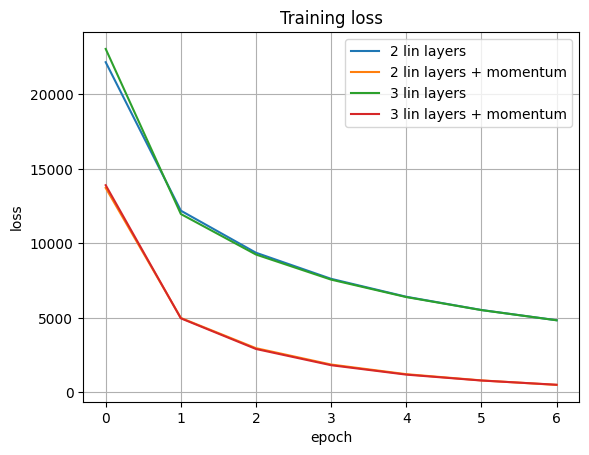

In [52]:
plt.plot(results['MLP2']['SGD']['train_loss'], label='2 lin layers')
plt.plot(results['MLP2']['momentum']['train_loss'], label='2 lin layers + momentum')
plt.plot(results['MLP3']['SGD']['train_loss'], label='3 lin layers')
plt.plot(results['MLP3']['momentum']['train_loss'], label='3 lin layers + momentum')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.title('Training loss')
plt.show()

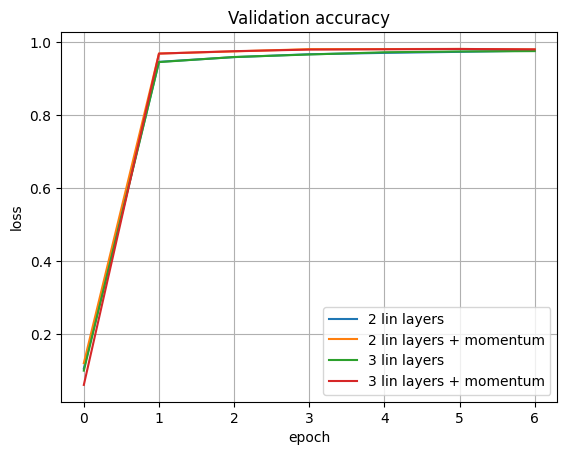

In [54]:
plt.plot(results['MLP2']['SGD']['val_acc'], label='2 lin layers')
plt.plot(results['MLP2']['momentum']['val_acc'], label='2 lin layers + momentum')
plt.plot(results['MLP3']['SGD']['val_acc'], label='3 lin layers')
plt.plot(results['MLP3']['momentum']['val_acc'], label='3 lin layers + momentum')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.title('Validation accuracy')
plt.show()

## Part 3 - PyTorch

### Question 11 - 60-minuts blitz

#### Tensors

In [79]:
import torch
import numpy as np

Create tensor from another tensor

In [80]:
x_data = torch.tensor([
    [1, 2],
    [3, 4]
])

In [81]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.0121, 0.6877],
        [0.1075, 0.3579]]) 



Create random tensor

In [82]:
shape = (2, 3,)
rand_tensor = torch.rand(shape) # uniform distribution on [0, 1)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.5885, 0.3190, 0.2424],
        [0.3649, 0.2799, 0.0273]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


#### Building classifier

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [42]:
batch_size = 128
epochs = 5
learning_rate = 0.001
momentum = 0.9


In [43]:
# data preparation
# - reshape to [1, 32, 32]
# - normalize

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [96]:
trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)

In [97]:
# trainset, valset = torch.utils.data.random_split(trainset, [55000, 5000])

In [98]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [99]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

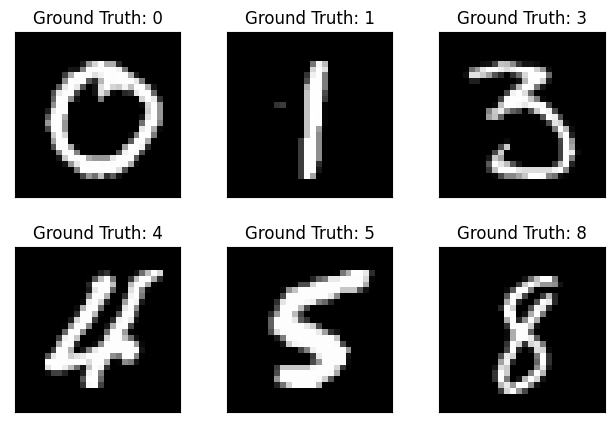

In [100]:
# functions to show an image
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [101]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) # [1, 28, 28] -> [6, 28, 28]
        self.pool1 = nn.MaxPool2d(2, 2) # [6, 28, 28] -> [6, 14, 14]
        self.conv2 = nn.Conv2d(6, 16, 5) # [6, 14, 14] -> [16, 10, 10]
        self.pool2 = nn.MaxPool2d(2, 2) # [16, 10, 10] -> [16, 5, 5]
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # [400] -> [120]
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        # return self.softmax(x)
        return x

In [102]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [110]:
losses = {}
for lr in [0.01, 0.03, 0.001, 0.003]:
    print(lr)
    
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    loss_train = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 100 mini-batches
                loss_train.append(running_loss / 50)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
                running_loss = 0.0

    losses.update({
        lr: {
            'loss_train': loss_train,
            'net': net
        }
    })

    print('Finished Training')

0.01
[1,    50] loss: 2.300
[1,   100] loss: 2.294
[1,   150] loss: 2.288
[1,   200] loss: 2.282
[1,   250] loss: 2.270
[1,   300] loss: 2.253
[1,   350] loss: 2.222
[1,   400] loss: 2.149
[1,   450] loss: 1.944
[2,    50] loss: 1.122
[2,   100] loss: 0.726
[2,   150] loss: 0.581
[2,   200] loss: 0.515
[2,   250] loss: 0.452
[2,   300] loss: 0.409
[2,   350] loss: 0.399
[2,   400] loss: 0.366
[2,   450] loss: 0.353
[3,    50] loss: 0.317
[3,   100] loss: 0.321
[3,   150] loss: 0.289
[3,   200] loss: 0.279
[3,   250] loss: 0.281
[3,   300] loss: 0.268
[3,   350] loss: 0.244
[3,   400] loss: 0.229
[3,   450] loss: 0.228
[4,    50] loss: 0.207
[4,   100] loss: 0.211
[4,   150] loss: 0.205
[4,   200] loss: 0.206
[4,   250] loss: 0.182
[4,   300] loss: 0.193
[4,   350] loss: 0.174
[4,   400] loss: 0.182
[4,   450] loss: 0.157
[5,    50] loss: 0.170
[5,   100] loss: 0.161
[5,   150] loss: 0.154
[5,   200] loss: 0.150
[5,   250] loss: 0.150
[5,   300] loss: 0.139
[5,   350] loss: 0.141
[5,   

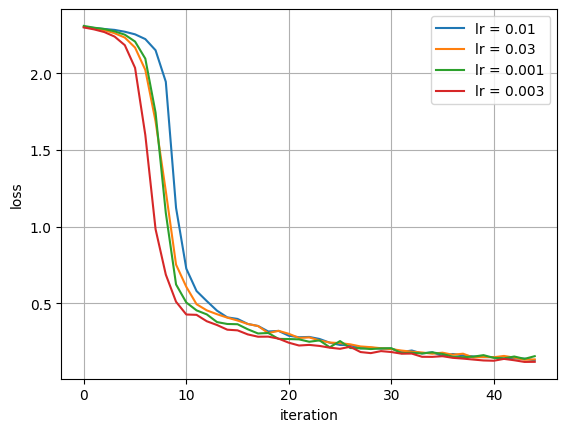

In [112]:
plt.plot(losses[0.01]['loss_train'], label='lr = 0.01')
plt.plot(losses[0.03]['loss_train'], label='lr = 0.03')
plt.plot(losses[0.001]['loss_train'], label='lr = 0.001')
plt.plot(losses[0.003]['loss_train'], label='lr = 0.003')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [116]:
for lr in losses.keys():
    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            # outputs = net(images)
            outputs = losses[lr]['net'](images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network (lr = {lr}) on the 10000 test images: {100 * correct // total} %')

Accuracy of the network (lr = 0.01) on the 10000 test images: 96 %
Accuracy of the network (lr = 0.03) on the 10000 test images: 96 %
Accuracy of the network (lr = 0.001) on the 10000 test images: 95 %
Accuracy of the network (lr = 0.003) on the 10000 test images: 96 %


In [117]:
# prepare to count predictions for each class
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = losses[0.003]['net'](images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 99.3 %
Accuracy for class: 1     is 98.9 %
Accuracy for class: 2     is 98.9 %
Accuracy for class: 3     is 95.9 %
Accuracy for class: 4     is 96.2 %
Accuracy for class: 5     is 93.4 %
Accuracy for class: 6     is 96.6 %
Accuracy for class: 7     is 93.3 %
Accuracy for class: 8     is 95.5 %
Accuracy for class: 9     is 94.9 %


### Question 12

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [17]:
epochs = 10
batch_size = 64
learning_rate = 0.001
momentum = 0.9


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
class Net_1(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = '1_conv_layer'
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 16, 5) # [1, 32, 32] -> [16, 28, 28]
        self.pool1 = nn.MaxPool2d(2, 2) # [16, 28, 28] -> [16, 14, 14]
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 14 * 14,512)  # 5*5 from image dimension
        self.fc2 = nn.Linear(512, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
class Net_2(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = '2_conv_layers'
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
class Net_3(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = '3_conv_layers'
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2) # [1, 32, 32] -> [6, 32, 32]
        self.pool1 = nn.MaxPool2d(2, 2) # [16, 32, 32] -> [16, 16, 16]

        self.conv2 = nn.Conv2d(6, 16, 5, padding=2) # [6, 16, 16] -> [16, 16, 16]
        self.pool2 = nn.MaxPool2d(2, 2) # [16, 16, 16] -> [16, 8, 8]

        self.conv3 = nn.Conv2d(16, 64, 5, padding=2) # [16, 8, 8] -> [64, 8, 8]
        self.pool3 = nn.MaxPool2d(2, 2) # [64, 8, 8] -> [64, 4, 4]
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # 5*5 from image dimension
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
from tqdm.notebook import tqdm

In [18]:
stat = {}
for net_cls in [Net_1, Net_2, Net_3]:
    net = net_cls()
    print(net)

    criterion = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    loss_history = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in tqdm(enumerate(trainloader, 0)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            every_n_iter = 100
            if i % every_n_iter == (every_n_iter - 1):
                loss_history.append(running_loss / every_n_iter)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / every_n_iter:.3f}')
                running_loss = 0.0
    print('Finished Training')

    stat[net.name] = {
        'net': net,
        'train_loss': loss_history
    }
    


Net_1(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


0it [00:00, ?it/s]

[1,   100] loss: 2.301
[1,   200] loss: 2.291
[1,   300] loss: 2.274
[1,   400] loss: 2.231
[1,   500] loss: 2.150
[1,   600] loss: 2.049
[1,   700] loss: 1.989


0it [00:00, ?it/s]

[2,   100] loss: 1.882
[2,   200] loss: 1.844
[2,   300] loss: 1.792
[2,   400] loss: 1.759
[2,   500] loss: 1.741
[2,   600] loss: 1.678
[2,   700] loss: 1.655


0it [00:00, ?it/s]

[3,   100] loss: 1.604
[3,   200] loss: 1.572
[3,   300] loss: 1.564
[3,   400] loss: 1.538
[3,   500] loss: 1.531
[3,   600] loss: 1.495
[3,   700] loss: 1.490


0it [00:00, ?it/s]

[4,   100] loss: 1.464
[4,   200] loss: 1.459
[4,   300] loss: 1.437
[4,   400] loss: 1.414
[4,   500] loss: 1.361
[4,   600] loss: 1.390
[4,   700] loss: 1.368


0it [00:00, ?it/s]

[5,   100] loss: 1.337
[5,   200] loss: 1.342
[5,   300] loss: 1.323
[5,   400] loss: 1.314
[5,   500] loss: 1.310
[5,   600] loss: 1.308
[5,   700] loss: 1.324


0it [00:00, ?it/s]

[6,   100] loss: 1.268
[6,   200] loss: 1.265
[6,   300] loss: 1.269
[6,   400] loss: 1.260
[6,   500] loss: 1.254
[6,   600] loss: 1.246
[6,   700] loss: 1.241


0it [00:00, ?it/s]

[7,   100] loss: 1.233
[7,   200] loss: 1.200
[7,   300] loss: 1.181
[7,   400] loss: 1.204
[7,   500] loss: 1.182
[7,   600] loss: 1.200
[7,   700] loss: 1.175


0it [00:00, ?it/s]

[8,   100] loss: 1.157
[8,   200] loss: 1.151
[8,   300] loss: 1.161
[8,   400] loss: 1.142
[8,   500] loss: 1.119
[8,   600] loss: 1.130
[8,   700] loss: 1.159


0it [00:00, ?it/s]

[9,   100] loss: 1.103
[9,   200] loss: 1.111
[9,   300] loss: 1.098
[9,   400] loss: 1.114
[9,   500] loss: 1.101
[9,   600] loss: 1.083
[9,   700] loss: 1.071


0it [00:00, ?it/s]

[10,   100] loss: 1.059
[10,   200] loss: 1.050
[10,   300] loss: 1.052
[10,   400] loss: 1.055
[10,   500] loss: 1.038
[10,   600] loss: 1.026
[10,   700] loss: 1.033
Finished Training
Net_2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


0it [00:00, ?it/s]

[1,   100] loss: 2.304
[1,   200] loss: 2.304
[1,   300] loss: 2.302
[1,   400] loss: 2.301
[1,   500] loss: 2.298
[1,   600] loss: 2.295
[1,   700] loss: 2.293


0it [00:00, ?it/s]

[2,   100] loss: 2.281
[2,   200] loss: 2.268
[2,   300] loss: 2.235
[2,   400] loss: 2.177
[2,   500] loss: 2.102
[2,   600] loss: 2.066
[2,   700] loss: 2.041


0it [00:00, ?it/s]

[3,   100] loss: 1.979
[3,   200] loss: 1.955
[3,   300] loss: 1.915
[3,   400] loss: 1.910
[3,   500] loss: 1.872
[3,   600] loss: 1.860
[3,   700] loss: 1.839


0it [00:00, ?it/s]

[4,   100] loss: 1.784
[4,   200] loss: 1.754
[4,   300] loss: 1.733
[4,   400] loss: 1.709
[4,   500] loss: 1.689
[4,   600] loss: 1.692
[4,   700] loss: 1.660


0it [00:00, ?it/s]

[5,   100] loss: 1.618
[5,   200] loss: 1.624
[5,   300] loss: 1.608
[5,   400] loss: 1.593
[5,   500] loss: 1.571
[5,   600] loss: 1.568
[5,   700] loss: 1.560


0it [00:00, ?it/s]

[6,   100] loss: 1.526
[6,   200] loss: 1.526
[6,   300] loss: 1.523
[6,   400] loss: 1.523
[6,   500] loss: 1.506
[6,   600] loss: 1.507
[6,   700] loss: 1.502


0it [00:00, ?it/s]

[7,   100] loss: 1.489
[7,   200] loss: 1.451
[7,   300] loss: 1.477
[7,   400] loss: 1.455
[7,   500] loss: 1.449
[7,   600] loss: 1.440
[7,   700] loss: 1.421


0it [00:00, ?it/s]

[8,   100] loss: 1.421
[8,   200] loss: 1.433
[8,   300] loss: 1.415
[8,   400] loss: 1.413
[8,   500] loss: 1.362
[8,   600] loss: 1.405
[8,   700] loss: 1.403


0it [00:00, ?it/s]

[9,   100] loss: 1.378
[9,   200] loss: 1.389
[9,   300] loss: 1.373
[9,   400] loss: 1.378
[9,   500] loss: 1.333
[9,   600] loss: 1.363
[9,   700] loss: 1.359


0it [00:00, ?it/s]

[10,   100] loss: 1.330
[10,   200] loss: 1.351
[10,   300] loss: 1.334
[10,   400] loss: 1.332
[10,   500] loss: 1.329
[10,   600] loss: 1.302
[10,   700] loss: 1.325
Finished Training
Net_3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


0it [00:00, ?it/s]

[1,   100] loss: 2.303
[1,   200] loss: 2.304
[1,   300] loss: 2.303
[1,   400] loss: 2.303
[1,   500] loss: 2.302
[1,   600] loss: 2.300
[1,   700] loss: 2.300


0it [00:00, ?it/s]

[2,   100] loss: 2.298
[2,   200] loss: 2.297
[2,   300] loss: 2.296
[2,   400] loss: 2.294
[2,   500] loss: 2.291
[2,   600] loss: 2.285
[2,   700] loss: 2.278


0it [00:00, ?it/s]

[3,   100] loss: 2.232
[3,   200] loss: 2.163
[3,   300] loss: 2.072
[3,   400] loss: 2.006
[3,   500] loss: 1.968
[3,   600] loss: 1.925
[3,   700] loss: 1.913


0it [00:00, ?it/s]

[4,   100] loss: 1.860
[4,   200] loss: 1.858
[4,   300] loss: 1.810
[4,   400] loss: 1.804
[4,   500] loss: 1.758
[4,   600] loss: 1.726
[4,   700] loss: 1.725


0it [00:00, ?it/s]

[5,   100] loss: 1.674
[5,   200] loss: 1.666
[5,   300] loss: 1.635
[5,   400] loss: 1.637
[5,   500] loss: 1.632
[5,   600] loss: 1.609
[5,   700] loss: 1.601


0it [00:00, ?it/s]

[6,   100] loss: 1.584
[6,   200] loss: 1.578
[6,   300] loss: 1.542
[6,   400] loss: 1.544
[6,   500] loss: 1.518
[6,   600] loss: 1.520
[6,   700] loss: 1.490


0it [00:00, ?it/s]

[7,   100] loss: 1.471
[7,   200] loss: 1.471
[7,   300] loss: 1.459
[7,   400] loss: 1.458
[7,   500] loss: 1.438
[7,   600] loss: 1.445
[7,   700] loss: 1.432


0it [00:00, ?it/s]

[8,   100] loss: 1.405
[8,   200] loss: 1.406
[8,   300] loss: 1.359
[8,   400] loss: 1.381
[8,   500] loss: 1.375
[8,   600] loss: 1.353
[8,   700] loss: 1.338


0it [00:00, ?it/s]

[9,   100] loss: 1.315
[9,   200] loss: 1.331
[9,   300] loss: 1.346
[9,   400] loss: 1.328
[9,   500] loss: 1.280
[9,   600] loss: 1.322
[9,   700] loss: 1.290


0it [00:00, ?it/s]

[10,   100] loss: 1.278
[10,   200] loss: 1.261
[10,   300] loss: 1.259
[10,   400] loss: 1.240
[10,   500] loss: 1.259
[10,   600] loss: 1.235
[10,   700] loss: 1.246
Finished Training


In [20]:
import matplotlib.pyplot as plt

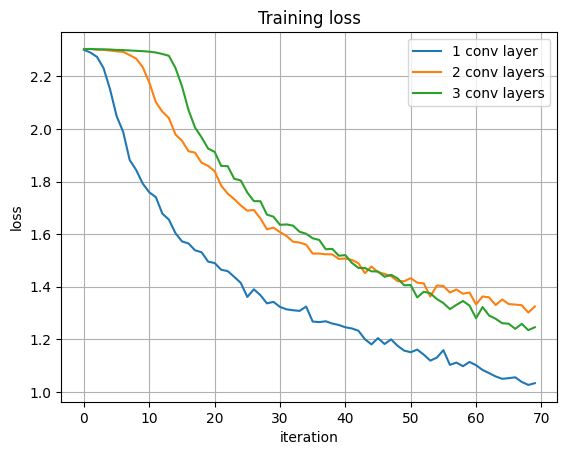

In [24]:
plt.plot(stat['1_conv_layer']['train_loss'], label='1 conv layer')
plt.plot(stat['2_conv_layers']['train_loss'], label='2 conv layers')
plt.plot(stat['3_conv_layers']['train_loss'], label='3 conv layers')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.title('Training loss')
plt.show()

In [26]:
for key, val in stat.items():  
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = val['net'](images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network with {key} on the 10000 test images: {100 * correct // total} %')

Accuracy of the network with 1_conv_layer on the 10000 test images: 59 %
Accuracy of the network with 2_conv_layers on the 10000 test images: 51 %
Accuracy of the network with 3_conv_layers on the 10000 test images: 55 %


In [27]:
!pip install torchsummary

In [29]:
from torchsummary import summary

for key, val in stat.items(): 
    print(summary(val['net'], (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Linear-3                  [-1, 512]       1,606,144
            Linear-4                   [-1, 84]          43,092
            Linear-5                   [-1, 10]             850
Total params: 1,651,302
Trainable params: 1,651,302
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 6.30
Estimated Total Size (MB): 6.44
----------------------------------------------------------------
None
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [